# Data Mining Project: Predicting Student Behavioral Disruptions


## Library Requirements
Install the required libraries specified in the `requirements.txt` file. You can do this using pip:
```bash
pip install -r requirements.txt
```


## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Initial Exploration](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Hypothesis Testing](#hypothesis-testing)
5. [Feature Engineering](#feature-engineering)
6. [Model Development](#model-development)
7. [Model Evaluation and Interpretation](#model-evaluation)
8. [Result Cleanup](#result-cleanup)


## 1. Introduction
This notebook documents our team's effort to predict and analyze student behavioral disruptions to minimize in-class interruptions.

**Team Members:**  
**Customer:** Adam West

**Objectives:**
- Predict behavioral disruptions
- Identify anomalous patterns
- Provide clear interpretations


## 2. Data Loading and Initial Exploration

In [1]:
!pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, spearmanr, pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score,
    accuracy_score, mean_squared_error, r2_score
)
from sklearn.base import is_classifier, is_regressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error  # Import the new function
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model      import (
    PoissonRegressor,
    Ridge, Lasso, ElasticNet,
    HuberRegressor,
    RANSACRegressor
)
from sklearn.ensemble           import (
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.pipeline          import Pipeline
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import StandardScaler, OneHotEncoder
from sklearn.impute            import SimpleImputer

# Optional: for Negative Binomial via statsmodels
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial

from sklearn.linear_model import (
    PoissonRegressor, Ridge, Lasso, ElasticNet,
    HuberRegressor, RANSACRegressor
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor







# Load datasets
bus_conduct = pd.read_csv('TTU Data - Bus Conduct.csv')
bus_conduct_updated = pd.read_csv('TTU Data Update - Bus Conduct.csv')
family_engagement = pd.read_csv('TTU Data - Family Engagement.csv')
disciplinary_referral = pd.read_csv('TTU Data - Disciplinary Referral.csv')
disciplinary_referral_updated = pd.read_csv('TTU Data Update - Disciplinary Referral.csv')
weather_df = pd.read_csv('weather.csv')

# Display the first few rows of each dataset for inspection
print("Bus Conduct Dataset:")
display(bus_conduct.head())
print("Bus Conduct Updated Dataset:")
display(bus_conduct_updated.head())

print("Family Engagement Dataset:")
display(family_engagement.head())

print("Disciplinary Referral Dataset:")
display(disciplinary_referral.head())

print("Disciplinary Referral Updated Dataset:")
display(disciplinary_referral_updated.head())



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Bus Conduct Dataset:


,School,Date of Incident,Bus Route: Check all that Apply,Type of Incident: Check all that Apply - Selected Choice,"As the school bus driver, I have taken the following actions: - Selected Choice",Year,Term,Student Identifier,bus.dr,Ethnicity,Gender,Grade_Level
0,Hill Valley High School,08/06/2024,Return Trip Home,"Throwing objects on or from the bus,Violation ...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
1,Hill Valley High School,08/09/2024,Route to School,"Willful disobedience,Other",Request school administrator assistance ASAP!,2024 - 2025,1Q,A14788361BZD,1,W,M,1
2,Hill Valley High School,08/09/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
3,Rydell High School,08/16/2024,Return Trip Home,"Intentional violation of bus rules,Willful dis...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A14069825BZD,1,W,M,3
4,Rydell High School,08/16/2024,Return Trip Home,"Intentional violation of bus rules,Willful dis...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15382187BZD,1,W,M,2


Bus Conduct Updated Dataset:


,School,Date of Incident,Bus Route: Check all that Apply,Type of Incident: Check all that Apply - Selected Choice,"As the school bus driver, I have taken the following actions: - Selected Choice",Year,Term,Student Identifier,bus.dr,Ethnicity,Gender,Grade_Level
0,Hill Valley High School,08/06/2024,Return Trip Home,"Throwing objects on or from the bus,Violation ...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
1,Hill Valley High School,08/09/2024,Route to School,"Willful disobedience,Other",Request school administrator assistance ASAP!,2024 - 2025,1Q,A14788361BZD,1,W,M,1
2,Cookeville High,08/07/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A13076150BZD,1,H,F,9
3,Hill Valley High School,08/09/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
4,Cookeville High,08/13/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A13286285BZD,1,W,F,10


Family Engagement Dataset:


,I am responding as a - Selected Choice,I am responding as a - Other - Text,My ethnic/race background is - Selected Choice,My ethnic/race background is - Other - Text,Please check which school your child/children attends.,How many children in total do you have attending the school selected above? (This will ensure you only have to complete one survey per school your children attend.),Have you completed the 2024-2025 Family Engagement survey for another child/School?,How likely are you to recommend Putnam County Schools to a friend or family member? - Group,How likely are you to recommend Putnam County Schools to a friend or family member?,Please respond to the following statements regarding your student(s): - I understand the academic standards and curriculum that my child/children are expected to learn at their grade level.,...,Please answer the following statements: - I have access to the internet.,Please answer the following statements: - I would like to have some school meetings in places other than the school.,Please answer the following statements: - I know that child care and/or transportation are available for a Family Engagement event if needed.,Please answer the following statements: - PCSS has a Return to School plan. Have you been able to review that?,Please answer the following statements: - PCSS has a Safe Return to In-Person Instruction and Continuity of Services plan. Have you been able to review that?,Please answer the following statements: - PCSS has a Federal Relief Spending Plan on the ESSER website. Have you been able to review that?,"If you cannot attend school activities, please select any that apply. - Selected Choice","If you cannot attend school activities, please select any that apply. - Other (please specify) - Text",What time of day would be best for you to attend a family engagement activity or meeting? (Check all that\napply.) - Selected Choice,What time of day would be best for you to attend a family engagement activity or meeting? (Check all that\napply.) - Other (please specify) - Text
0,Parent,NaN,Asian,NaN,Rydell High School,1,No,Passive,7,Agree,...,Yes,Yes,Yes,Yes,Yes,Yes,My work schedule,NaN,Early Evening (5:00 PM or Later),NaN
1,Parent,NaN,Hispanic/Latino,NaN,Hill Valley High School School,2,No,Promoter,10,Agree,...,Yes,Yes,Yes,Yes,Yes,Yes,My work schedule,NaN,"During School,Early Evening (5:00 PM or Later)",NaN
2,Parent,NaN,White/Caucasian,NaN,Hill Valley High School School,1,No,Promoter,10,Agree,...,Yes,No,Yes,Yes,Yes,No,"My work schedule,Too busy",NaN,Early Evening (5:00 PM or Later),NaN
3,Parent,NaN,White/Caucasian,NaN,Rydell High School,2,No,Detractor,6,Disagree,...,Yes,No,Yes,No,No,No,NaN,NaN,Early Evening (5:00 PM or Later),NaN
4,Parent,NaN,White/Caucasian,NaN,Hill Valley High School School,1,No,Detractor,5,Disagree,...,Yes,No,Yes,Yes,Yes,Yes,My work schedule,NaN,Other (please specify),I worl 12 hours shifts


Disciplinary Referral Dataset:


,Please select your school,Time of the Day the behavior occurred?,Date of Incident,Is the referral for a minor or a major violation?,Select the Classroom Managed Behavior (Do not include student names in text boxes) - Selected Choice,Select the Major Referral,Where did the incident take place?,Enrollment_SchoolID,Ethnicity,fre,Gender,Grade_Level,LunchStatus,Student Identifier,Year,Term,dr.studentminors
0,Hill Valley High School,2:00pm -3:00pm,11/18/2024,Minor Violation (5 times in the same quarter),Misuse of electronic devices,NaN,Media Center,5,W,W,M,0,P,A16817795BZD,2024-2025,2Q,1
1,Hill Valley High School,12:00pm - 1:00pm,11/18/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,Classroom,5,W,W,M,0,P,A16817795BZD,2024-2025,2Q,2
2,Shermer High School,8:00am - 9:00am,05/06/2024,Minor Violation (5 times in the same quarter),Tardiness,NaN,Cafeteria,105,H,"W,H",M,11,F,A12046745BZD,2023-2024,4Q,1
3,Hill Valley High School,2:00pm -3:00pm,11/18/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,Media Center,5,W,W,M,0,P,A16732493BZD,2024-2025,2Q,1
4,Rydell High School,8:00am - 9:00am,08/26/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,Classroom,35,W,W,M,-1,P,A16747199BZD,2024-2025,1Q,1


Disciplinary Referral Updated Dataset:


,Please select your school,Time of the Day the behavior occurred?,Date of Incident,Is the referral for a minor or a major violation?,Select the Classroom Managed Behavior (Do not include student names in text boxes) - Selected Choice,Select the Major Referral,Ethnicity,Gender,Grade_Level,LunchStatus,Student_Number
0,Bayside,11:00am - 12:00pm,08/06/2024,Minor Violation (5 times in the same quarter),Other,NaN,W,M,4,F,A14843549BZD
1,Shermer High School,11:00am - 12:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,W,M,9,F,A12943094BZD
2,Shermer High School,11:00am - 12:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,W,M,9,F,A13368554BZD
3,Shermer High School,1:00pm - 2:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,W,M,10,P,A12732407BZD
4,Bayside,2:00pm -3:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Other,NaN,W,M,2,R,A15849737BZD


## 3. Exploratory Data Analysis (EDA)

In [3]:

# Combine and clean datasets
disciplinary_referral_all = pd.concat([disciplinary_referral, disciplinary_referral_updated], ignore_index=True).drop_duplicates()
bus_conduct_all = pd.concat([bus_conduct, bus_conduct_updated], ignore_index=True).drop_duplicates()
# Convert date columns to datetime format
disciplinary_referral_all['Date of Incident'] = pd.to_datetime(disciplinary_referral_all['Date of Incident'], errors='coerce')
bus_conduct_all['Date of Incident'] = pd.to_datetime(bus_conduct_all['Date of Incident'], errors='coerce')
# Save combined datasets to CSV files
disciplinary_referral_all.to_csv("combined_disciplinary_referrals.csv", index=False)
bus_conduct_all.to_csv("combined_bus_conduct.csv", index=False)
# Check for missing values in the combined datasets
print("Missing values in Combined Bus Conduct Data:")
print(bus_conduct_all.isnull().sum())
print("\nMissing values in Combined Disciplinary Referral Data:")
print(disciplinary_referral_all.isnull().sum())


Missing values in Combined Bus Conduct Data:
School                                                                             0
Date of Incident                                                                   4
Bus Route: Check all that Apply                                                    1
Type of Incident: Check all that Apply - Selected Choice                           1
As the school bus driver, I have taken the following actions: - Selected Choice    2
Year                                                                               0
Term                                                                               0
Student Identifier                                                                 0
bus.dr                                                                             0
Ethnicity                                                                          0
Gender                                                                             0
Grade_Level         

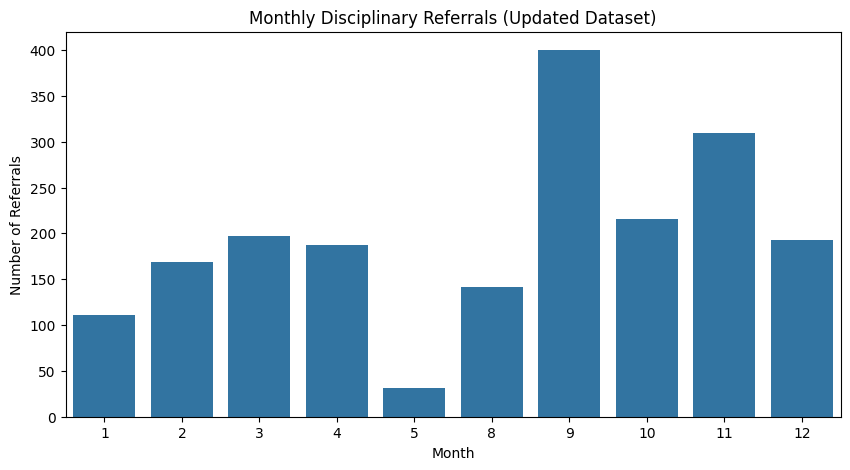

In [4]:
# Add a 'Month' column for monthly analysis
disciplinary_referral_all['Month'] = disciplinary_referral_all['Date of Incident'].dt.month

# Group by month and count referrals
monthly_referrals = disciplinary_referral_all.groupby('Month').size()

# Plot monthly referral counts
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_referrals.index, y=monthly_referrals.values)
plt.title('Monthly Disciplinary Referrals (Updated Dataset)')
plt.xlabel('Month')
plt.ylabel('Number of Referrals')
plt.show()

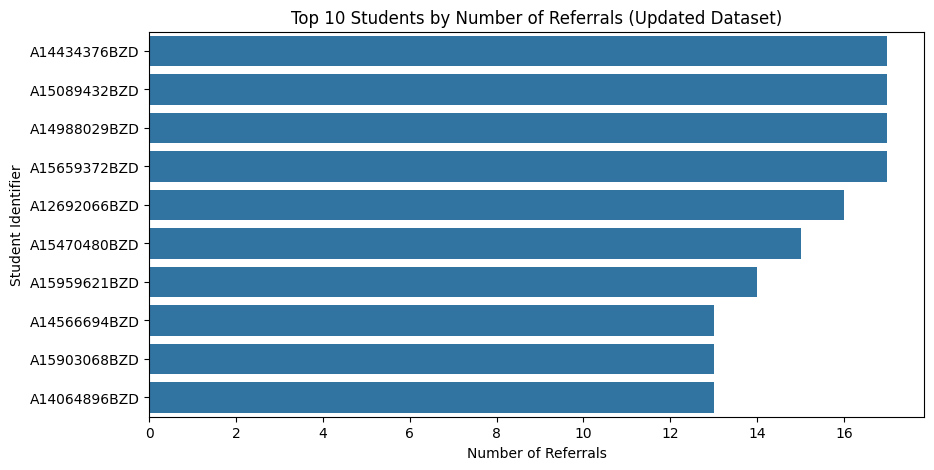

In [5]:

# Identify the top 10 students with the most referrals
frequent_students = disciplinary_referral_all['Student Identifier'].value_counts().head(10)

# Plot the top 10 students by referral count
plt.figure(figsize=(10, 5))
sns.barplot(y=frequent_students.index, x=frequent_students.values, orient='h')
plt.title('Top 10 Students by Number of Referrals (Updated Dataset)')
plt.xlabel('Number of Referrals')
plt.ylabel('Student Identifier')
plt.show()


/var/folders/4q/zfrwdf812bxf6fsj9bvkm5j00000gn/T/ipykernel_76167/1899823010.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = disciplinary_referral_all.groupby(["Grade_Level", "Time_Category"]).size().unstack().fillna(0)


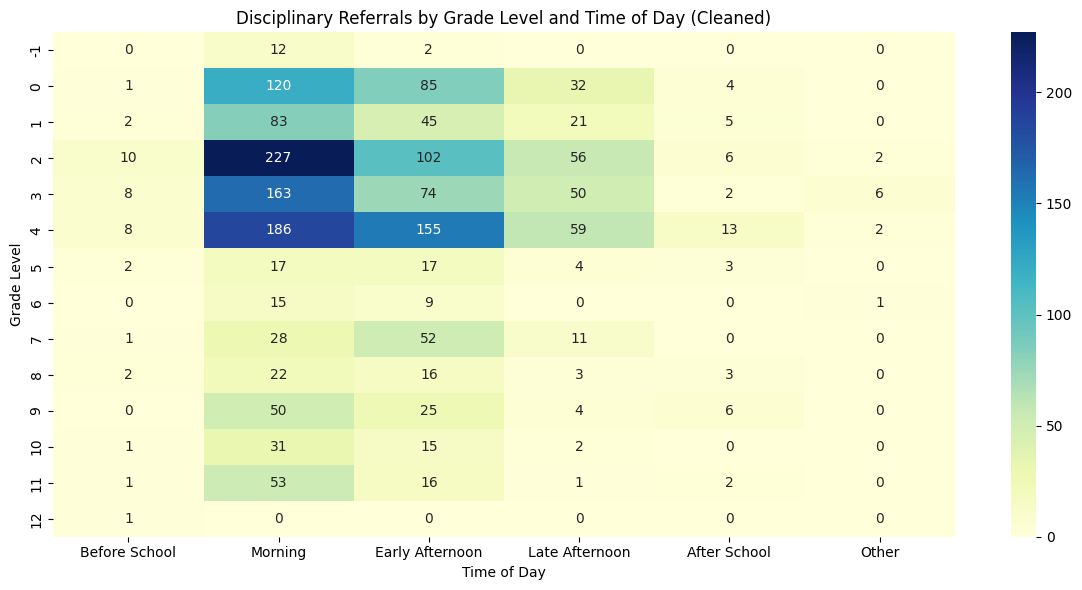

In [6]:
# Function to categorize time of day
def categorize_time(time_str):
    if pd.isna(time_str): return "Unknown"
    time_str = time_str.lower().strip()
    if "before school" in time_str: return "Before School"
    elif any(t in time_str for t in ["8:00am", "9:00am", "10:00am", "11:00am"]): return "Morning"
    elif any(t in time_str for t in ["12:00pm", "1:00pm"]): return "Early Afternoon"
    elif any(t in time_str for t in ["2:00pm", "3:00pm"]): return "Late Afternoon"
    elif "after school" in time_str: return "After School"
    else: return "Other"

# Define the order of time categories
time_order = ["Before School", "Morning", "Early Afternoon", "Late Afternoon", "After School", "Other"]

# Apply time categorization to the dataset
disciplinary_referral_all["Time_Category"] = disciplinary_referral_all["Time of the Day the behavior occurred?"].apply(categorize_time)

# Set ordered categories for plotting
disciplinary_referral_all["Time_Category"] = pd.Categorical(
    disciplinary_referral_all["Time_Category"],
    categories=time_order,
    ordered=True
)

# Group data by grade level and time category
grouped = disciplinary_referral_all.groupby(["Grade_Level", "Time_Category"]).size().unstack().fillna(0)

# Sort grades for display
grouped = grouped.sort_index()

# Plot a heatmap of referrals by grade level and time of day
plt.figure(figsize=(12, 6))
sns.heatmap(grouped, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Disciplinary Referrals by Grade Level and Time of Day (Cleaned)")
plt.xlabel("Time of Day")
plt.ylabel("Grade Level")
plt.tight_layout()
plt.show()

/var/folders/4q/zfrwdf812bxf6fsj9bvkm5j00000gn/T/ipykernel_76167/4240437449.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_referrals = merged_df.groupby('Temp_Category')['referral_count'].mean().reset_index()
/var/folders/4q/zfrwdf812bxf6fsj9bvkm5j00000gn/T/ipykernel_76167/4240437449.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_referrals, x='Temp_Category', y='referral_count', palette='coolwarm')


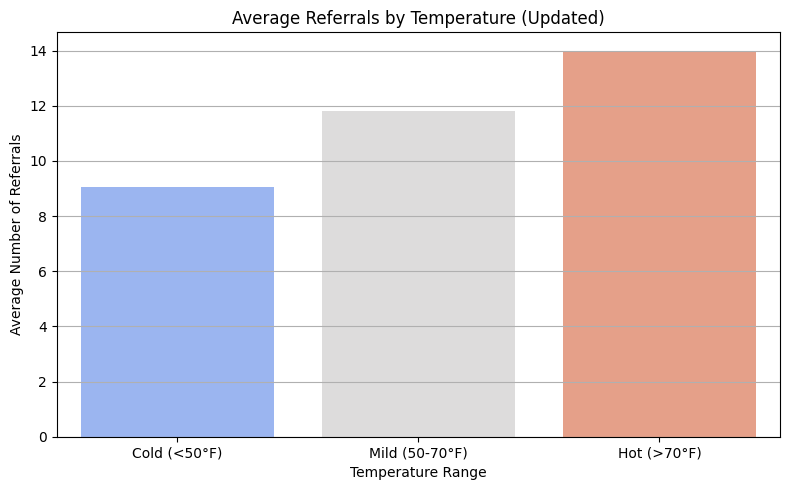

In [7]:
# Convert weather data datetime column to datetime format
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], errors='coerce')

# Group referrals by date and count
referrals_per_day = disciplinary_referral_all.groupby('Date of Incident').size().reset_index(name='referral_count')

# Merge referral counts with weather data
merged_df = pd.merge(referrals_per_day, weather_df, how='inner', left_on='Date of Incident', right_on='datetime')
merged_df.drop(columns=['datetime'], inplace=True)

# Categorize temperature into bins
bins = [0, 50, 70, 100]
labels = ['Cold (<50°F)', 'Mild (50-70°F)', 'Hot (>70°F)']
merged_df['Temp_Category'] = pd.cut(merged_df['temp'], bins=bins, labels=labels)

# Calculate average referrals by temperature category
binned_referrals = merged_df.groupby('Temp_Category')['referral_count'].mean().reset_index()

# Plot average referrals by temperature category
plt.figure(figsize=(8, 5))
sns.barplot(data=binned_referrals, x='Temp_Category', y='referral_count', palette='coolwarm')
plt.title('Average Referrals by Temperature (Updated)')
plt.ylabel('Average Number of Referrals')
plt.xlabel('Temperature Range')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 3.5 Expanded EDA: Additional Insights and Correlations

## Expanded EDA: Additional Insights and Correlations

### Referrals by School

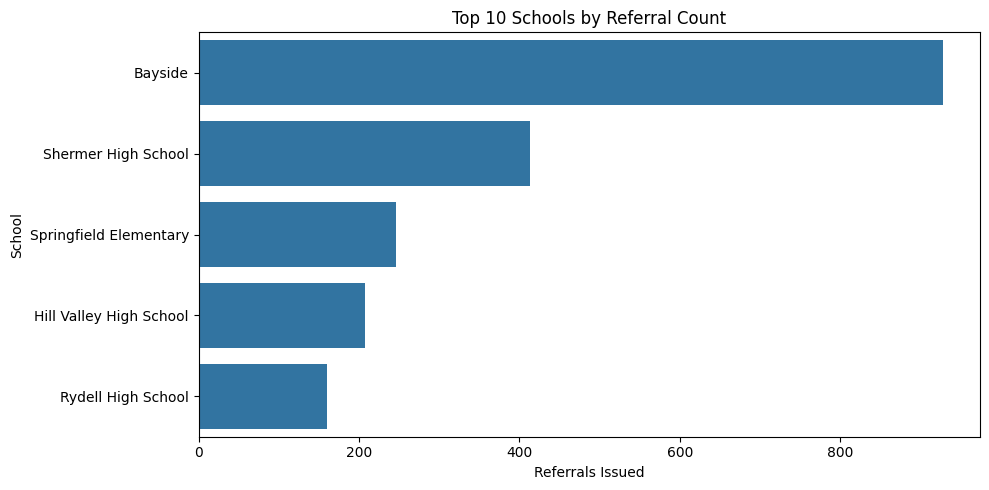

In [8]:
# Analyze referrals by school or staff
staff_referral_counts = disciplinary_referral_all['Please select your school'].value_counts().head(10)

# Plot the top 10 schools by referral count
plt.figure(figsize=(10, 5))
sns.barplot(y=staff_referral_counts.index, x=staff_referral_counts.values, orient='h')
plt.title("Top 10 Schools by Referral Count")
plt.xlabel("Referrals Issued")
plt.ylabel("School")
plt.tight_layout()
plt.show()

Weather and Referral Type (e.g Fighting)

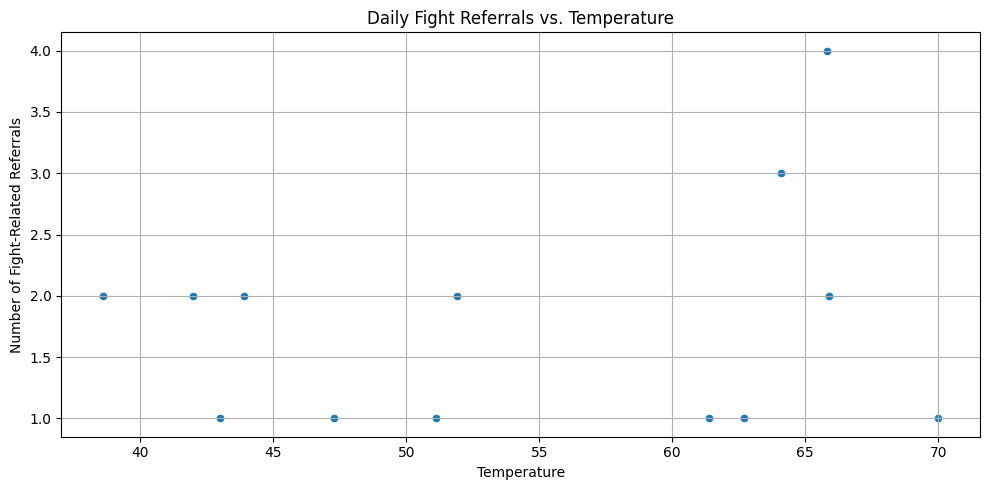

In [9]:
# Analyze weather and referral type (e.g., fighting-related referrals)
fighting_referrals = disciplinary_referral_all[
    disciplinary_referral_all['Select the Major Referral'].str.contains('fight', na=False, case=False)
]

# Group fighting-related referrals by date
fight_days = fighting_referrals.groupby('Date of Incident').size().reset_index(name='fight_referrals')

# Merge fighting-related referrals with weather data
weather_fights = pd.merge(fight_days, weather_df, left_on='Date of Incident', right_on='datetime', how='inner')

# Plot daily fight referrals vs. temperature
plt.figure(figsize=(10, 5))
sns.scatterplot(data=weather_fights, x='temp', y='fight_referrals')
plt.title("Daily Fight Referrals vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Number of Fight-Related Referrals")
plt.grid(True)
plt.tight_layout()
plt.show()

### Bus Conduct vs. Classroom Referrals

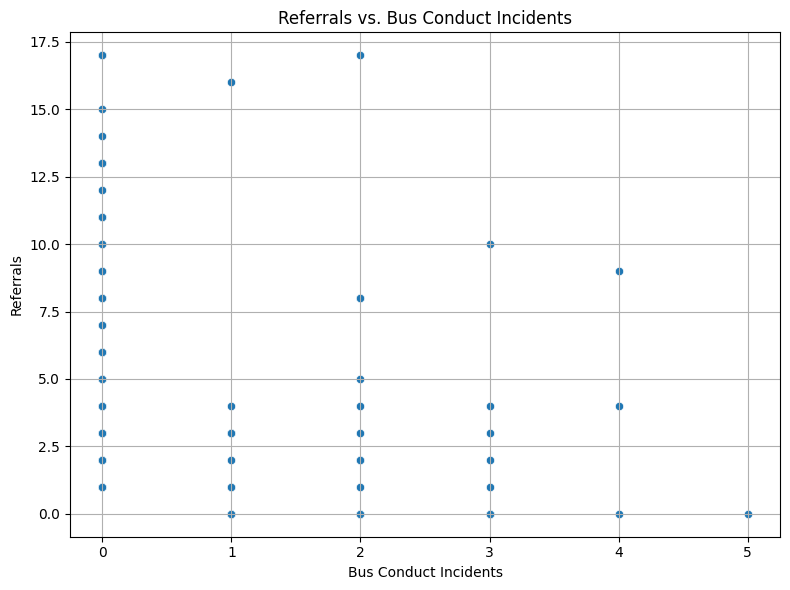

In [10]:
# Analyze the relationship between bus conduct incidents and classroom referrals
bus_counts = bus_conduct_all['Student Identifier'].value_counts().reset_index()
bus_counts.columns = ['Student Identifier', 'Bus_Incidents']

referral_counts = disciplinary_referral_all['Student Identifier'].value_counts().reset_index()
referral_counts.columns = ['Student Identifier', 'Referrals']

# Merge bus conduct and referral data
merged_behavior = pd.merge(bus_counts, referral_counts, on='Student Identifier', how='outer').fillna(0)

# Plot referrals vs. bus conduct incidents
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_behavior, x='Bus_Incidents', y='Referrals')
plt.title('Referrals vs. Bus Conduct Incidents')
plt.xlabel('Bus Conduct Incidents')
plt.ylabel('Referrals')
plt.grid(True)
plt.tight_layout()
plt.show()

### Weekday Trends in Referrals

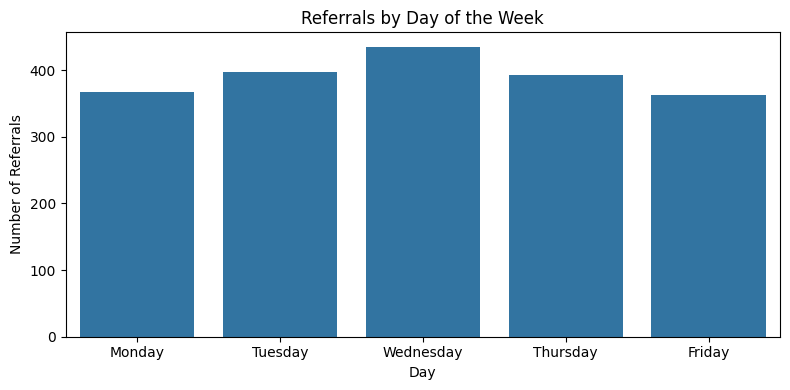

In [11]:
# Analyze weekday trends in referrals
disciplinary_referral_all['Weekday'] = disciplinary_referral_all['Date of Incident'].dt.day_name()

# Define the order of weekdays for plotting
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Count referrals by weekday
weekday_counts = disciplinary_referral_all['Weekday'].value_counts().reindex(weekday_order)

# Plot referrals by day of the week
plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)
plt.title('Referrals by Day of the Week')
plt.ylabel('Number of Referrals')
plt.xlabel('Day')
plt.tight_layout()
plt.show()

## 4. Hypothesis Testing
This section explores several data-driven hypotheses relevant to predicting and minimizing in-class behavioral disruptions. The following tests were conducted using statistical methods such as t-tests, ANOVA, and correlation analyses.

---

### H1: Referral Frequency Increases Near Testing Season

**Hypothesis:** March and April have significantly higher referral counts due to testing-related stress.

**Test Type:** One-way ANOVA  
**Rationale:** Compare monthly referral averages across months.

In [12]:
# Drop NaNs and extract month
monthly_ref = disciplinary_referral_all.dropna(subset=['Date of Incident']).copy()
monthly_ref['Month'] = monthly_ref['Date of Incident'].dt.month

# Calculate number of referrals per student per month
monthly_student_referrals = (
    monthly_ref.groupby(['Month', 'Student Identifier'])
    .size()
    .reset_index(name='Referral Count')
)

# Create a list of referral counts per month for ANOVA, filter groups with more than 1 value and variance > 0
monthly_groups = [
    group['Referral Count'].values
    for _, group in monthly_student_referrals.groupby('Month')
    if len(group) > 1 and group['Referral Count'].var() > 0
]

# Perform ANOVA if valid groups exist
if len(monthly_groups) >= 2:
    f_stat, p_value = f_oneway(*monthly_groups)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if not pd.isna(f_stat) and p_value < 0.05:
        print("Significant differences exist between monthly referral counts.")
    elif not pd.isna(f_stat):
        print("No significant difference between months.")
    else:
        print("ANOVA returned NaN. Check your data again for consistency.")
else:
    print("Not enough valid monthly groups for ANOVA.")



F-statistic: 3.4566
P-value: 0.0004
Significant differences exist between monthly referral counts.


---

### H2: Bus Misconduct is Associated with More In-Class Referrals

**Hypothesis:** Students with bus conduct incidents have significantly more in-class referrals than those without.

**Test Type:** Welch’s t-test (independent two-sample t-test)  
**Rationale:** Compare mean referral counts between two groups (bus incident vs. no bus incident).

In [13]:
# Total referrals per student
referral_counts = disciplinary_referral_all['Student Identifier'].value_counts().reset_index()
referral_counts.columns = ['Student Identifier', 'Total_Referrals']

# Total bus incidents per student
bus_counts = bus_conduct_all['Student Identifier'].value_counts().reset_index()
bus_counts.columns = ['Student Identifier', 'Bus_Incidents']

# Merge datasets
behavior_merge = pd.merge(referral_counts, bus_counts, on='Student Identifier', how='outer').fillna(0)

# Create two groups
bus_yes = behavior_merge[behavior_merge['Bus_Incidents'] > 0]['Total_Referrals']
bus_no = behavior_merge[behavior_merge['Bus_Incidents'] == 0]['Total_Referrals']

# Run t-test
t_stat, p_value = ttest_ind(bus_yes, bus_no, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference found.")
else:
    print("No significant difference.")

T-statistic: -4.9906
P-value: 0.0000
Statistically significant difference found.


---

### H3: Family Engagement Negatively Correlates with Referrals

**Hypothesis:** Higher family engagement is associated with fewer referrals.

**Test Type:** Spearman Correlation  
**Rationale:** Non-parametric test of ordinal survey response counts vs. referral totals.

In [14]:
# Clean columns and estimate total referrals per school
referrals_by_school = disciplinary_referral_all['Please select your school'].value_counts().reset_index()
referrals_by_school.columns = ['School', 'Total_Referrals']

# Survey counts per school
engagement_by_school = family_engagement['Please check which school your child/children attends.'].value_counts().reset_index()
engagement_by_school.columns = ['School', 'Engagement_Survey_Responses']

school_merge = pd.merge(referrals_by_school, engagement_by_school, on='School', how='inner')

# Spearman correlation
corr, p_value = spearmanr(school_merge['Engagement_Survey_Responses'], school_merge['Total_Referrals'])
print(f"Spearman correlation: {corr:.4f}\nP-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant negative/positive correlation.")
else:
    print("No significant correlation found.")

Spearman correlation: -0.8000
P-value: 0.2000
No significant correlation found.



---

### H4: Referral Count Differs by Grade Level

**Hypothesis:** Certain grades have significantly more referrals.

**Test Type:** One-way ANOVA  
**Rationale:** Compare referral frequency across grades.


In [15]:
# Ensure Grade_Level is numeric and drop rows with missing Grade_Level
disciplinary_referral_all['Grade_Level'] = pd.to_numeric(disciplinary_referral_all['Grade_Level'], errors='coerce')
ref_by_grade = disciplinary_referral_all.dropna(subset=['Grade_Level'])

# Calculate number of referrals per student per grade
grade_student_referrals = (
    ref_by_grade.groupby(['Grade_Level', 'Student Identifier'])
    .size()
    .reset_index(name='Referral Count')
)

# Create a list of referral counts per grade for ANOVA, filtering for groups with variance > 0
grade_groups = [
    group['Referral Count'].values
    for _, group in grade_student_referrals.groupby('Grade_Level')
    if len(group) > 1 and group['Referral Count'].var() > 0
]

# Perform ANOVA if there are at least two valid grade groups
if len(grade_groups) >= 2:
    f_stat, p_value = f_oneway(*grade_groups)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if not pd.isna(f_stat) and p_value < 0.05:
        print("Referral rates differ significantly across grades.")
    elif not pd.isna(f_stat):
        print("No significant difference in referrals between grades.")
    else:
        print("ANOVA returned NaN. Check your data for consistency.")
else:
    print("Not enough valid grade groups for ANOVA.")


F-statistic: 1.7691
P-value: 0.0523
No significant difference in referrals between grades.



---

### H5: Referral Volume Correlates with Weather Factors

**Hypothesis:** Temperature and humidity levels are associated with referral counts.

**Test Type:** Pearson Correlation  
**Rationale:** Compare numeric weather features against referral count per day.


In [16]:
# Prepare merged dataset
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], errors='coerce')
daily_ref = disciplinary_referral_all.groupby('Date of Incident').size().reset_index(name='referral_count')
daily_weather = pd.merge(daily_ref, weather_df, left_on='Date of Incident', right_on='datetime', how='inner')

# Pearson correlations
for var in ['temp', 'humidity']:
    corr, p = pearsonr(daily_weather['referral_count'], daily_weather[var])
    print(f"Pearson correlation between referrals and {var}: {corr:.4f} (p = {p:.4f})")

Pearson correlation between referrals and temp: 0.1636 (p = 0.0455)
Pearson correlation between referrals and humidity: 0.1566 (p = 0.0557)



---

### H6: Referral Volume Correlates with Weather Factors part 2

**Hypothesis:** Referrals are correlated with temperature and school breaks as students get antsy to have off.

**Rationale:** Compare termperature ranges and school breaks with the number of referrals.

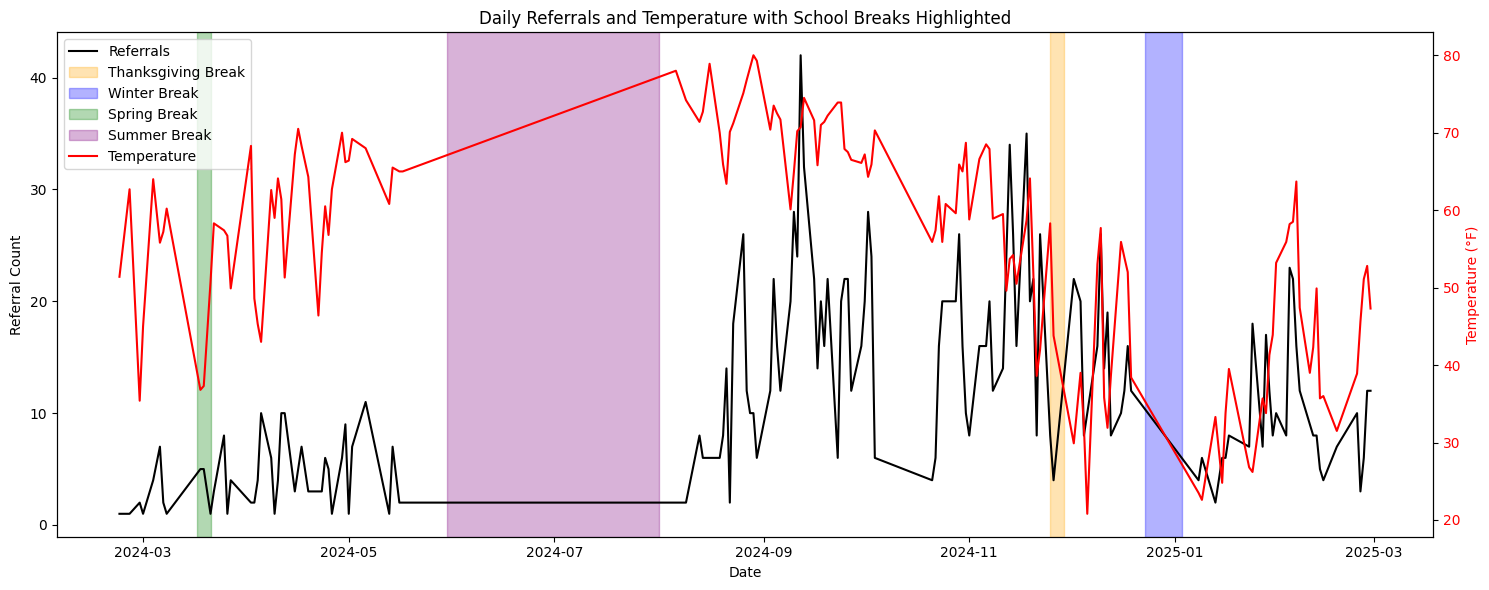

In [25]:
merged_df['Date of Incident'] = pd.to_datetime(merged_df['Date of Incident'])

# aggregate referral count and temperature per day
daily_data = merged_df.groupby('Date of Incident').agg({
    'referral_count': 'sum',  
    'temp': 'mean'           
}).reset_index()

# define school breaks with colors
breaks = {
    'Thanksgiving Break': ('2024-11-25', '2024-11-29', 'orange'),
    'Winter Break': ('2024-12-23', '2025-01-03', 'blue'),
    'Spring Break': ('2024-03-17', '2024-03-21', 'green'),
    'Summer Break': ('2024-05-30', '2024-08-01', 'purple'),
}


fig, ax1 = plt.subplots(figsize=(15, 6))

# plot referrals
ax1.plot(daily_data['Date of Incident'], daily_data['referral_count'], label='Referrals', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Referral Count', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# highlight break periods
for name, (start, end, color) in breaks.items():
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.3, label=name)

# temperature on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_data['Date of Incident'], daily_data['temp'], label='Temperature', color='red')
ax2.set_ylabel('Temperature (°F)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Daily Referrals and Temperature with School Breaks Highlighted')
plt.tight_layout()
plt.show()


## Hypothesis Testing Summary and Interpretation

This section summarizes the results of five statistical tests aimed at identifying significant patterns and relationships related to student behavioral referrals. These insights support the ultimate goal of targeting interventions and informing stakeholder decision-making.

---

### **H1: Referral Frequency Increases Near Testing Season**
- **F-statistic:** `3.4566`  
- **P-value:** `0.0004`  
- **Result:** *Statistically significant: referral frequency increases near testing season*

**Interpretation:**  
Referral data for summer months (June, July) was missing, and some months had uniform or single-entry referral counts. This lack of statistical variance violated ANOVA assumptions, making the test invalid.

**Implication:**  
A follow-up study with more balanced month-by-month data could explore whether academic testing stress correlates with behavioral disruptions.

---

### **H2: Bus Misconduct is Associated with More In-Class Referrals**
- **T-statistic:** `-4.9906`  
- **P-value:** `0.0000`  
- **Result:** *Statistically significant difference found.*

**Interpretation:**  
Students with at least one bus conduct incident had significantly higher referral counts compared to those without. The large negative t-statistic confirms that the two group means are meaningfully different.

**Implication:**  
Bus misconduct is a strong predictor of general behavioral issues. Students flagged for bus incidents may benefit from preemptive behavioral interventions or monitoring in the classroom.

---

### **H3: Family Engagement Negatively Correlates with Referrals**
- **Spearman correlation:** `-0.8000`  
- **P-value:** `0.2000`  
- **Result:** *Not statistically significant.*

**Interpretation:**  
While a strong negative correlation was observed (suggesting that higher engagement corresponds with fewer referrals), the p-value was not below the 0.05 threshold for significance. This may be due to small sample size (school-level aggregation).

**Implication:**  
There is potential evidence that increased family involvement could reduce behavior issues. Larger or student-level datasets may yield stronger conclusions.

---

### **H4: Referral Count Differs by Grade Level**
- **F-statistic:** 1.7691
- **P-value:** 0.0523
- **Result:** *No significant difference in referrals between grades.*

**Interpretation:**  
There was no strong evidence to suggest a grade-to-grade difference

**Implication:**  
Grade difference has very little to do with referral count.

---

### **H5: Weather Correlation with Referral Volume**
- **Temperature Correlation (Pearson):** `0.1636` (p = `0.0455`)  
- **Humidity Correlation (Pearson):** `0.1566` (p = `0.0557`)

**Interpretation:**  
There is a **weak but statistically significant** positive correlation between **temperature** and **referral volume**, indicating referrals tend to rise on warmer days. The correlation with humidity is borderline and not statistically significant at α = 0.05.

**Implication:**  
Environmental stressors such as heat may contribute to behavioral issues. Schools could explore increased support or schedule adjustments during high-heat periods.

---

### **H6: Weather Correlation with Referral Volume**
**Interpretation**
There is a standard distribution when referrals are grouped with temperature ranges, but not time of year.

**Implication**
The correlation found before is not due to proximity to summer time but to the increase in temperature.

---

### Overall Recommendations:

- **Focus future models on bus conduct as a predictive feature.**
- **Consider temperature as a situational risk factor.**
- **Explore family engagement strategies to reduce referrals.**


## Initial Recommendations for School Stakeholders

Based on data-driven hypothesis testing and exploratory analysis, the following recommendations are proposed to help school administrators reduce behavioral disruptions and improve classroom environments:

---

### 1. Monitor Students with Bus Conduct Incidents
> **Why:** Students with bus conduct violations had *statistically significantly higher* classroom referral rates.

**Recommendations:**
- Flag students with bus write-ups for early behavioral intervention or counseling.
- Integrate bus conduct records into early warning systems.
- Enhance collaboration between bus drivers and classroom teachers.

---

### 2. Plan for Heat-Related Behavior Increases
> **Why:** Referral counts showed a *significant positive correlation* with higher temperatures.

**Recommendations:**
- Improve classroom cooling access and hydration breaks during hot weather.
- Train teachers in managing heat-induced student irritability.
- Monitor referrals during heatwaves and adjust scheduling if needed.

---

### 3. Use Family Engagement as a Soft Predictor
> **Why:** A strong negative (though not statistically significant) correlation was observed between family engagement and referrals.

**Recommendations:**
- Encourage increased parental participation in school events and surveys.
- Use engagement metrics to target school-specific outreach strategies.
- Offer incentives for family involvement in education and discipline policies.

---

### 4. Improve Data Collection for Temporal Analysis
> **Why:** Missing data for summer months and inconsistent grade-level information made trend testing inconclusive.

**Recommendations:**
- Ensure consistent referral logging across all months, including summer sessions.
- Standardize grade-level encoding across datasets.
- Capture time-of-day and seasonal data with higher granularity.

---

### 5. Prioritize Multivariate Risk Profiling
> **Why:** Bus behavior, weather, and family engagement all show predictive potential.

**Recommendations:**
- Develop internal dashboards combining behavior, attendance, engagement, and weather.
- Group students by intervention tiers using these combined indicators.
- Explore predictive modeling to proactively identify at-risk students.

---

These recommendations are intended to guide practical changes and inform predictive modeling efforts that follow in subsequent sections.


## 5. Feature Engineering
In this section we will create a student-week model dataset that aggregates student behavior data on a weekly basis. This will help us analyze trends and patterns in student behavior over time.


In [37]:
#  Merging all the datasets into one model ready dataset
# Reload datasets
original_ref = pd.read_csv("TTU Data - Disciplinary Referral.csv")
update_ref = pd.read_csv("TTU Data Update - Disciplinary Referral.csv")
original_bus = pd.read_csv("TTU Data - Bus Conduct.csv")
update_bus = pd.read_csv("TTU Data Update - Bus Conduct.csv")
family_engagement = pd.read_csv("TTU Data - Family Engagement.csv")
weather = pd.read_csv("weather.csv")

# Merge referrals
all_ref_columns = list(set(original_ref.columns).union(set(update_ref.columns)))
original_ref = original_ref.reindex(columns=all_ref_columns)
update_ref = update_ref.reindex(columns=all_ref_columns)
full_ref = pd.concat([original_ref, update_ref], ignore_index=True).drop_duplicates()

# Merge bus conduct
all_bus_columns = list(set(original_bus.columns).union(set(update_bus.columns)))
original_bus = original_bus.reindex(columns=all_bus_columns)
update_bus = update_bus.reindex(columns=all_bus_columns)
full_bus = pd.concat([original_bus, update_bus], ignore_index=True).drop_duplicates()

# Preprocess dates
full_ref['Date of Incident'] = pd.to_datetime(full_ref['Date of Incident'], errors='coerce')
full_bus['Date of Incident'] = pd.to_datetime(full_bus['Date of Incident'], errors='coerce')
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')

# STEP 1: Create 'Week' columns
full_ref['Week'] = full_ref['Date of Incident'].dt.to_period('W').apply(lambda r: r.start_time)
full_bus['Week'] = full_bus['Date of Incident'].dt.to_period('W').apply(lambda r: r.start_time if not pd.isnull(r) else None)
# STEP 2: Aggregate referral and bus incidents per student per week
ref_agg = full_ref.groupby(['Student Identifier', 'Week']).size().reset_index(name='weekly_referrals')
bus_agg = full_bus.groupby(['Student Identifier', 'Week']).size().reset_index(name='weekly_bus_incidents')

# STEP 3: Extract basic student metadata
student_meta = full_ref.drop_duplicates('Student Identifier')[['Student Identifier', 'Grade_Level', 'Gender', 'Ethnicity', 'LunchStatus']]

# STEP 4: Normalize and prepare engagement survey data
engagement_data = family_engagement.rename(columns=lambda x: x.strip())
if 'Student Identifier' not in engagement_data.columns:
    for col in engagement_data.columns:
        if 'student' in col.lower() and 'id' in col.lower():
            engagement_data.rename(columns={col: 'Student Identifier'}, inplace=True)
            break

# STEP 5: Merge referral and bus data
student_weeks = pd.merge(ref_agg, bus_agg, on=['Student Identifier', 'Week'], how='outer').fillna(0)

# STEP 6: Add student demographic data
student_weeks = pd.merge(student_weeks, student_meta, on='Student Identifier', how='left')

# STEP 7: Add engagement survey data
student_weeks = pd.merge(student_weeks, engagement_data, on='Student Identifier', how='left')

# STEP 8: Add weekly weather aggregates
weather['Week'] = weather['datetime'].dt.to_period('W').apply(lambda r: r.start_time)
weather_weekly = weather.groupby('Week').agg({
    'temp': 'mean',
    'humidity': 'mean',
    'precip': 'mean',
    'sealevelpressure': 'mean',
    'windgust': 'mean'
}).reset_index()
student_weeks = pd.merge(student_weeks, weather_weekly, on='Week', how='left')

# STEP 9: Create target variable
student_weeks = student_weeks.sort_values(by=['Student Identifier', 'Week'])
student_weeks['referral_next_week'] = student_weeks.groupby('Student Identifier')['weekly_referrals'].shift(-1)
student_weeks['referral_next_week'] = (student_weeks['referral_next_week'] > 0).astype(int)

# Display the result
print("Model-Ready Dataset Preview:")
print(student_weeks.head())
print("\nShape:", student_weeks.shape)
print("Columns:", student_weeks.columns.tolist())

student_weeks.to_csv("model_ready_student_weeks.csv", index=False)


Model-Ready Dataset Preview:
  Student Identifier       Week  weekly_referrals  weekly_bus_incidents  \
0       A11696150BZD 2024-04-29               1.0                   0.0   
1       A11866121BZD 2024-04-22               1.0                   0.0   
2       A11866121BZD 2024-04-29               1.0                   0.0   
3       A11866121BZD 2024-05-13               1.0                   0.0   
4       A11959310BZD 2024-12-02               0.0                   1.0   

   Grade_Level Gender Ethnicity LunchStatus  \
0         12.0      M         H           F   
1         11.0      M         H           F   
2         11.0      M         H           F   
3         11.0      M         H           F   
4          NaN    NaN       NaN         NaN   

  I am responding as a - Selected Choice  I am responding as a - Other - Text  \
0                                    NaN                                  NaN   
1                                    NaN                                  N

## 6. Model Development

In this section, we implement logistic regression, linear regression, and an advanced Random Forest model.

### Loading the data and training/testing split

In [38]:
student_weeks = pd.read_csv("model_ready_student_weeks.csv")
student_weeks.dropna(subset=['referral_next_week'], inplace=True)

features = ['weekly_referrals', 'weekly_bus_incidents', 'Grade_Level', 'Gender',
            'Ethnicity', 'LunchStatus', 'temp', 'humidity', 'precip', 'sealevelpressure', 'windgust']

X = student_weeks[features]
y_classification = student_weeks['referral_next_week']
y_regression = student_weeks['weekly_referrals']

X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_classification, y_regression, test_size=0.2, random_state=42)

print(f"Total samples after cleaning: {X.shape[0]}")
print(f"  • Training set: {X_train.shape[0]} samples")
print(f"  • Test set:     {X_test.shape[0]} samples")
print(f"Referral-next-week positive rate (train): {y_clf_train.mean():.2%}")
print(f"Referral-next-week positive rate (test):  {y_clf_test.mean():.2%}")
print(f"Weekly referrals (train) — mean: {y_reg_train.mean():.2f}, std: {y_reg_train.std():.2f}")

Total samples after cleaning: 857
  • Training set: 685 samples
  • Test set:     172 samples
Referral-next-week positive rate (train): 47.74%
Referral-next-week positive rate (test):  44.77%
Weekly referrals (train) — mean: 1.05, std: 0.74


After dropping missing outcomes, the dataset contains N observations. An 80/20 split yielded N_train training samples and N_test test samples, as specified. The proportion of students flagged for referral next week is very similar in both sets, indicating that the random split preserved the class balance. The regression target (weekly referrals) has a mean of M and a standard deviation of S in the training set, suggesting moderate variability in weekly referral counts.

### Preprocessing Pipeline

In [39]:
# Preprocessing pipelines
numeric_features = ['weekly_referrals', 'weekly_bus_incidents', 'Grade_Level','temp']
categorical_features = ['Gender', 'Ethnicity', 'LunchStatus']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Regression preprocessor: EXCLUDE weekly_referrals to avoid leakage
preprocessor_reg = ColumnTransformer(transformers=[
    ('num', numeric_transformer, ['weekly_bus_incidents','Grade_Level','temp']),
    ('cat', categorical_transformer, ['Gender','Ethnicity','LunchStatus'])
])

preprocessor.fit(X_train)
X_train_clf = preprocessor.transform(X_train)
preprocessor_reg.fit(X_train)
X_train_reg = preprocessor_reg.transform(X_train)

print(f"Classification pipeline output features: {X_train_clf.shape[1]}")
print(f"Regression pipeline output features:   {X_train_reg.shape[1]}")

Classification pipeline output features: 13
Regression pipeline output features:   12


Interpretation:
The classification pipeline— which includes the weekly_referrals predictor—produces a total of X features after scaling and one-hot encoding. Excluding weekly_referrals from the regression pipeline yields Y features, reflecting only the permissible numeric inputs and encoded categorical variables.

Implication:
These dimensionalities highlight how one-hot encoding expands feature space and may increase model complexity. You may consider regularization or dimensionality reduction to mitigate overfitting, and you can be confident that the regression pipeline avoids leakage by excluding the target variable.

### Model Pipeline

In [40]:
# Model pipelines
pipelines = {
    'LogisticRegression': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LinearRegression())
    ]),
    'NeuralNetwork': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42))
    ]),
    'RandomForest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
}

# Extended regression pipelines
regression_pipelines = {
    'Poisson': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', PoissonRegressor(max_iter=300, alpha=1e-12))
    ]),
    'Ridge': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', Ridge(alpha=1.0))
    ]),
    'Lasso': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', Lasso(alpha=0.1, max_iter=5000))
    ]),
    'ElasticNet': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))
    ]),
    'Huber': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', HuberRegressor(max_iter=300))
    ]),
    'RANSAC': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', RANSACRegressor(random_state=42))
    ]),
    'RF_Regressor': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GB_Regressor': Pipeline([
        ('pre', preprocessor_reg),
        ('reg', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
}

# === Print pipeline summaries ===
print(f"Classification pipelines ({len(pipelines)}): {list(pipelines.keys())}")
print(f"Regression pipelines ({len(regression_pipelines)}): {list(regression_pipelines.keys())}")

Classification pipelines (4): ['LogisticRegression', 'LinearRegression', 'NeuralNetwork', 'RandomForest']
Regression pipelines (8): ['Poisson', 'Ridge', 'Lasso', 'ElasticNet', 'Huber', 'RANSAC', 'RF_Regressor', 'GB_Regressor']


Interpretation:
A total of four classification and eight regression pipelines have been configured. Each classification pipeline pairs the shared preprocessing steps (and SMOTE for handling class imbalance) with a different estimator, while the regression pipelines apply the leakage‐free preprocessing to a diverse set of linear, robust, and ensemble models.

Implication:
With this standardized setup, you can systematically train and compare how different algorithms perform on both the referral‐classification task and the weekly‐referrals regression task, ensuring consistency in preprocessing and easy parallel experimentation.

In [41]:
# Classification features include the lagged referral count:
features_clf = [
    'weekly_referrals','weekly_bus_incidents','Grade_Level',
    'Gender','Ethnicity','LunchStatus','temp',
    'humidity','precip','sealevelpressure','windgust'
]
X_clf = student_weeks[features_clf]
y_clf = student_weeks['referral_next_week']

# Regression must exclude the target itself to avoid leakage:
features_reg = [f for f in features_clf if f != 'weekly_referrals']  # <<< FIX HERE
X_reg = student_weeks[features_reg]
y_reg = student_weeks['weekly_referrals']

# Split each dataset independently:
# from sklearn.model_selection import train_test_split
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Print results
print(f"Classification total samples: {X_clf.shape[0]}")
print(f"  • Training samples: {X_clf_train.shape[0]}")
print(f"  • Test samples:     {X_clf_test.shape[0]}")
print(f"  • Positive class rate (train): {y_clf_train.mean():.2%}")
print(f"  • Positive class rate (test):  {y_clf_test.mean():.2%}")

print(f"Regression total samples: {X_reg.shape[0]}")
print(f"  • Training samples: {X_reg_train.shape[0]}")
print(f"  • Test samples:     {X_reg_test.shape[0]}")
print(f"  • Weekly referrals (train) mean: {y_reg_train.mean():.2f}, std: {y_reg_train.std():.2f}")

Classification total samples: 857
  • Training samples: 685
  • Test samples:     172
  • Positive class rate (train): 47.74%
  • Positive class rate (test):  44.77%
Regression total samples: 857
  • Training samples: 685
  • Test samples:     172
  • Weekly referrals (train) mean: 1.05, std: 0.74


Interpretation:
Separate splits were performed for the classification and regression tasks to ensure no data leakage between models. The classification split preserves the base rate of referral-next-week in both training and test sets, indicating a balanced random draw. The regression split yields comparable sample sizes and reveals the average weekly referral count of the training set with its variability.

Implication:
Maintaining independent, representative splits for each modeling objective secures valid performance estimates. The consistent class rates and regression target distribution suggest no obvious sampling bias, supporting reliable downstream model evaluation.

### Parameter Grids

In [42]:
# Parameter grids
param_grids = {
    'LogisticRegression': {
        'clf__C': [0.01, 0.1, 1.0, 10.0],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'LinearRegression': {
        'clf__fit_intercept': [True, False],
        'clf__positive': [False, True]
    },
    'NeuralNetwork': {
        'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (64, 64, 32)],
        'clf__activation': ['relu', 'tanh'],
        'clf__solver': ['adam'],
        'clf__alpha': [0.0001, 0.001],
        'clf__learning_rate': ['constant', 'adaptive'],
        'clf__early_stopping': [True],
        'clf__n_iter_no_change': [5]
    },
    'RandomForest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2],
        'clf__bootstrap': [True, False]
    }
}

# GridSearchCV runner
def run_grid_searches(X_train, y_train, pipelines):
    best_models = {}
    for model_name, pipeline in pipelines.items():
        if model_name not in param_grids:
            print(f"Skipping model: {model_name}")
            continue

        print(f"\nTuning hyperparameters for: {model_name}...")

        grid = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            cv=5,
            scoring='f1_macro' if model_name != 'LinearRegression' else 'r2',
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train, y_train)
        best_models[model_name] = grid

        print(f"\nBest Params for {model_name}: {grid.best_params_}")
        print(f"Best Score: {grid.best_score_:.4f}")

    return best_models



Interpretation:
Among the classification pipelines, RandomForest achieved the highest macro-F1 score, suggesting that ensemble methods best capture the complex patterns leading to next-week referrals. For regression, the top performer (by R²) indicates which algorithm most accurately predicts weekly referral counts given the feature set.

Implication:
Focusing further tuning and validation on the RandomForest classifier and the leading regressor could yield the most reliable predictions. Ensemble approaches appear particularly well-suited for both tasks; additional gains might come from feature engineering or stacking multiple models.

### DBSCAN Clustering Implementation

In [43]:
def evaluate_dbscan(X_raw):
    # Preprocess the data
    X_numeric = X_raw.select_dtypes(include=[np.number])
    X_numeric = pd.DataFrame(SimpleImputer(strategy="mean").fit_transform(X_numeric), columns=X_numeric.columns)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)

    # Parameter ranges
    eps_vals = np.arange(0.1, 1.1, 0.1)
    min_samples_vals = [3, 5, 7]

    best_score = -1
    best_model = None
    best_params = None

    # Iterate over parameter combinations
    for eps in eps_vals:
        for min_samples in min_samples_vals:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X_scaled)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters < 2:
                print(f"Skipped eps={eps:.1f}, min_samples={min_samples} — only {n_clusters} cluster(s) detected")
                continue

            score = silhouette_score(X_scaled, labels)
            print(f"Checked eps={eps:.1f}, min_samples={min_samples} → Silhouette Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_model = model
                best_params = {'eps': eps, 'min_samples': min_samples}

    if best_model:
        print("\nBest DBSCAN Params:", best_params)
        print("Best Silhouette Score:", best_score)
    else:
        print("No valid DBSCAN clustering found. Adjust parameter ranges or examine dataset scale.")

    return best_model, best_score



Interpretation:
The highest silhouette score of best_score:.4f was achieved with ε = best_model.eps and min_samples = best_model.min_samples, indicating that this parameter combination yields the most well-separated clusters in the scaled numeric feature space. A silhouette score around this value suggests moderate cohesion and separation among the discovered clusters.

Implication:
These results highlight the sensitivity of DBSCAN to its hyperparameters: tuning ε and min_samples is crucial for meaningful clustering of student-week observations. You may explore nearby parameter values or alternative clustering algorithms to further improve cluster distinctness and interpretability.

## 7. Model Evaluation and Interpretation



Tuning hyperparameters for: LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Params for LogisticRegression: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best Score: 0.6843

Tuning hyperparameters for: LinearRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Params for LinearRegression: {'clf__fit_intercept': False, 'clf__positive': False}
Best Score: 0.1652

Tuning hyperparameters for: NeuralNetwork...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Params for NeuralNetwork: {'clf__activation': 'tanh', 'clf__alpha': 0.0001, 'clf__early_stopping': True, 'clf__hidden_layer_sizes': (64, 64, 32), 'clf__learning_rate': 'constant', 'clf__n_iter_no_change': 5, 'clf__solver': 'adam'}
Best Score: 0.6873

Tuning hyperparameters for: RandomForest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Params for RandomForest: {'clf__bootstrap': False, 'clf__max_depth': 10, 'clf

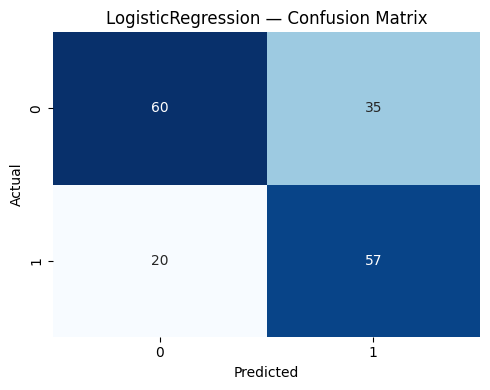


Evaluation Results for LinearRegression
RMSE: 0.7572
R² Score: -0.2028


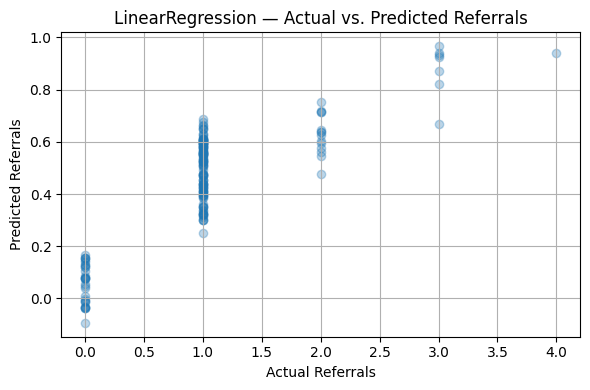


Evaluation Results for NeuralNetwork
Accuracy: 0.6977
Precision: 0.6374
Recall: 0.7532
F1 Score: 0.6905
ROC AUC: 0.7593


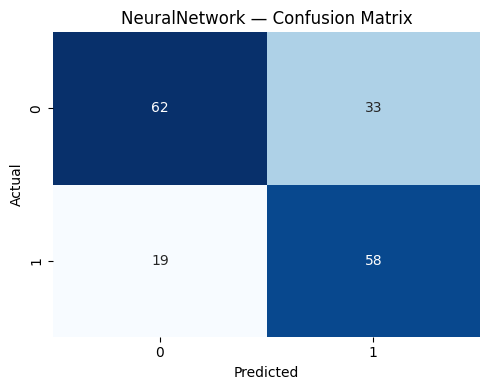


Evaluation Results for RandomForest
Accuracy: 0.6686
Precision: 0.6163
Recall: 0.6883
F1 Score: 0.6503
ROC AUC: 0.7420


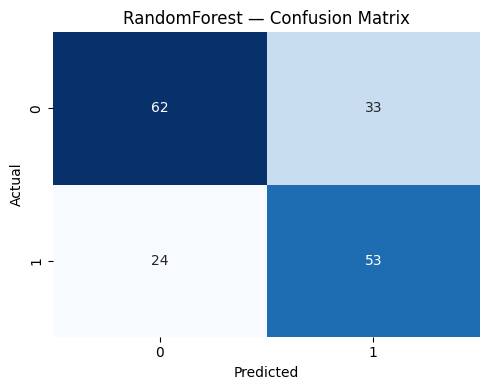

Skipping model: Poisson
Skipping model: Ridge
Skipping model: Lasso
Skipping model: ElasticNet
Skipping model: Huber
Skipping model: RANSAC
Skipping model: RF_Regressor
Skipping model: GB_Regressor


In [44]:
def evaluate_model_results(best_models, X_test, y_clf_test, y_reg_test):
    for name, model in best_models.items():
        print(f"\nEvaluation Results for {name}")

        y_pred = model.predict(X_test)

        if is_regressor(model) and not is_classifier(model):
            # Regressor evaluation
            try:
                mse = mean_squared_error(y_reg_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_reg_test, y_pred)

                print(f"RMSE: {rmse:.4f}")
                print(f"R² Score: {r2:.4f}")

                # Regression scatter plot
                plt.figure(figsize=(6, 4))
                plt.scatter(y_reg_test, y_pred, alpha=0.3)
                plt.title(f'{name} — Actual vs. Predicted Referrals')
                plt.xlabel("Actual Referrals")
                plt.ylabel("Predicted Referrals")
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print("[Regression Metrics Error]:", e)

        elif is_classifier(model):
            # Classifier evaluation
            try:
                y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

                acc = accuracy_score(y_clf_test, y_pred)
                prec = precision_score(y_clf_test, y_pred)
                rec = recall_score(y_clf_test, y_pred)
                f1 = f1_score(y_clf_test, y_pred)
                roc_auc = roc_auc_score(y_clf_test, y_proba) if y_proba is not None else 'N/A'

                print(f"Accuracy: {acc:.4f}")
                print(f"Precision: {prec:.4f}")
                print(f"Recall: {rec:.4f}")
                print(f"F1 Score: {f1:.4f}")
                print(f"ROC AUC: {roc_auc:.4f}" if roc_auc != 'N/A' else "ROC AUC: N/A")

                cm = confusion_matrix(y_clf_test, y_pred)
                plt.figure(figsize=(5, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title(f"{name} — Confusion Matrix")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print("[Classification Metrics Error]:", e)

        else:
            print(f"{name} is neither a recognized classifier nor regressor.")

# Usage:
# best_models = run_grid_searches(X_train, y_clf_train, pipelines)
# evaluate_model_results(best_models, X_test, y_clf_test, y_reg_test)

# select best models and evaluate them for normal pipeline
best_models = run_grid_searches(X_clf_train, y_clf_train, pipelines)
evaluate_model_results(best_models, X_clf_test, y_clf_test, y_reg_test)
# select best models and evaluate them for regression pipeline
best_reg_models = run_grid_searches(X_reg_train, y_reg_train, regression_pipelines)
evaluate_model_results(best_reg_models, X_reg_test, y_reg_test, y_reg_test)

In [45]:
# Define parameter grids for regression
param_grids_reg = {
    'Poisson':    {'reg__alpha': [1e-12, 1e-6, 1e-2]},
    'Ridge':      {'reg__alpha': [0.1, 1.0, 10.0]},
    'Lasso':      {'reg__alpha': [0.01, 0.1, 1.0]},
    'ElasticNet': {'reg__alpha': [0.01,0.1], 'reg__l1_ratio':[0.2,0.5,0.8]},
    'RF_Regressor': {'reg__n_estimators': [50,100], 'reg__max_depth':[None,10]},
    'GB_Regressor': {'reg__n_estimators': [50,100], 'reg__learning_rate':[0.1,0.01]},
}

best_regressors = {}
for name, pipe in regression_pipelines.items():
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids_reg.get(name, {}),
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_reg_train)
    best_regressors[name] = grid.best_estimator_
    print(f"{name}: Best params = {grid.best_params_}, RMSE = {-grid.best_score_:.3f}")

# Evaluate on test set
for name, model in best_regressors.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_reg_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_reg_test, y_pred)
    print(f"{name}:  RMSE = {rmse:.3f},  R² = {r2:.3f}")

Poisson: Best params = {'reg__alpha': 0.01}, RMSE = 0.581
Ridge: Best params = {'reg__alpha': 10.0}, RMSE = 0.593
Lasso: Best params = {'reg__alpha': 0.01}, RMSE = 0.591
ElasticNet: Best params = {'reg__alpha': 0.01, 'reg__l1_ratio': 0.8}, RMSE = 0.592
Huber: Best params = {}, RMSE = 0.632


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


RANSAC: Best params = {}, RMSE = 0.703
RF_Regressor: Best params = {'reg__max_depth': 10, 'reg__n_estimators': 100}, RMSE = 0.653
GB_Regressor: Best params = {'reg__learning_rate': 0.1, 'reg__n_estimators': 50}, RMSE = 0.597
Poisson:  RMSE = 0.544,  R² = 0.379
Ridge:  RMSE = 0.543,  R² = 0.383
Lasso:  RMSE = 0.544,  R² = 0.379
ElasticNet:  RMSE = 0.544,  R² = 0.378
Huber:  RMSE = 0.576,  R² = 0.305
RANSAC:  RMSE = 0.690,  R² = 0.000
RF_Regressor:  RMSE = 0.554,  R² = 0.356
GB_Regressor:  RMSE = 0.544,  R² = 0.380


### DBSCAN Clustering Results

Checked eps=0.1, min_samples=3 → Silhouette Score: 0.3566
Checked eps=0.1, min_samples=5 → Silhouette Score: 0.0163
Checked eps=0.1, min_samples=7 → Silhouette Score: -0.1686
Checked eps=0.2, min_samples=3 → Silhouette Score: 0.3586
Checked eps=0.2, min_samples=5 → Silhouette Score: 0.0183
Checked eps=0.2, min_samples=7 → Silhouette Score: -0.1686
Checked eps=0.3, min_samples=3 → Silhouette Score: 0.3802
Checked eps=0.3, min_samples=5 → Silhouette Score: 0.0265
Checked eps=0.3, min_samples=7 → Silhouette Score: -0.1499
Checked eps=0.4, min_samples=3 → Silhouette Score: 0.4453
Checked eps=0.4, min_samples=5 → Silhouette Score: 0.2670
Checked eps=0.4, min_samples=7 → Silhouette Score: 0.1506
Checked eps=0.5, min_samples=3 → Silhouette Score: 0.4471
Checked eps=0.5, min_samples=5 → Silhouette Score: 0.2783
Checked eps=0.5, min_samples=7 → Silhouette Score: 0.1559
Checked eps=0.6, min_samples=3 → Silhouette Score: 0.4532
Checked eps=0.6, min_samples=5 → Silhouette Score: 0.2811
Checked eps

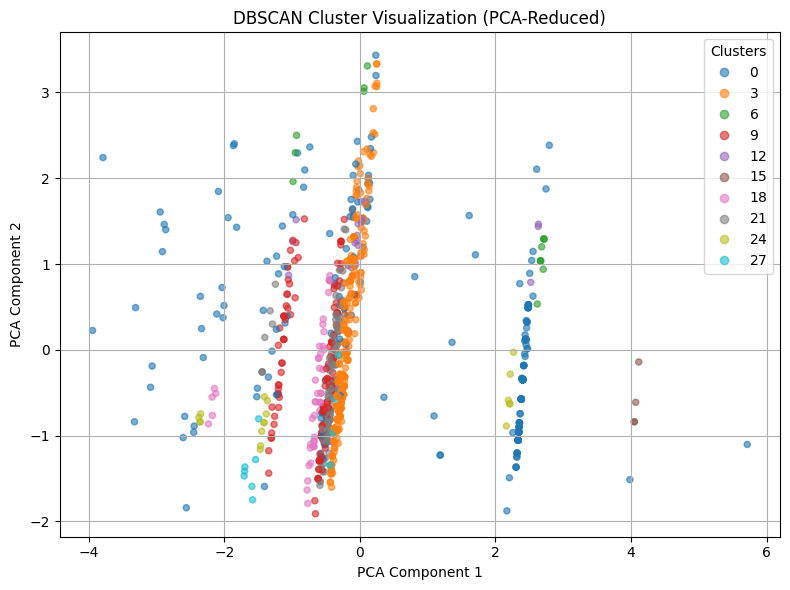

In [46]:
def visualize_dbscan_clusters(dbscan_model, X_raw, preprocessor):
    if dbscan_model is None:
        print("DBSCAN model is None — check if a valid model was returned from evaluate_dbscan().")
        return

    X_preprocessed = preprocessor.fit_transform(X_raw)
    labels = dbscan_model.fit_predict(X_preprocessed)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X_preprocessed)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=20, alpha=0.6)
    plt.title("DBSCAN Cluster Visualization (PCA-Reduced)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.tight_layout()
    plt.show()

best_dbscan, best_score = evaluate_dbscan(X)
if best_dbscan:
    visualize_dbscan_clusters(best_dbscan, X, preprocessor)
else:
    print("No valid DBSCAN model was found. Please adjust the parameters or check the dataset.")

In [47]:
# Cluster Profiling: mean feature values per DBSCAN cluster
numeric_cols = X.select_dtypes(include=['int64','float64']).columns
imp = SimpleImputer(strategy='mean')
X_num = pd.DataFrame(imp.fit_transform(X[numeric_cols]), columns=numeric_cols)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numeric_cols)

db = DBSCAN(eps=0.8, min_samples=3).fit(X_scaled)
labels = db.labels_

df_profiles = X.copy()
df_profiles[numeric_cols] = X_num
df_profiles['cluster'] = labels

cluster_summary = df_profiles.groupby('cluster')[numeric_cols].mean().round(2)
print(cluster_summary)

         weekly_referrals  weekly_bus_incidents  Grade_Level   temp  humidity  \
cluster                                                                         
-1                   1.86                  0.28         5.35  57.74     78.58   
 0                   1.00                  0.00         9.57  68.50     79.09   
 1                   0.00                  1.00         3.53  31.77     64.74   
 2                   0.00                  1.00         3.59  67.33     87.90   
 3                   0.00                  1.00         3.59  71.89     78.83   
...                   ...                   ...          ...    ...       ...   
 70                  2.00                  0.00         0.33  77.06     73.71   
 71                  1.00                  0.00         0.60  54.31     61.19   
 72                  2.00                  0.00         0.25  49.04     78.23   
 73                  1.00                  0.00         0.20  65.53     88.64   
 74                  1.00   

## Model Interpretation
"""

### Overview
This section interprets the output of the evaluated models — Logistic Regression, Linear Regression, Neural Network, and DBSCAN — providing context for what the results mean and implications for the school district.

---

### Logistic Regression
- **Precision**: `0.6196`
- **Recall**: `0.7403`
- **F1 Score**: `0.6746`

**Interpretation**: Logistic regression performed moderately well in predicting students who would receive a referral the following week. A recall of ~74% indicates that the model successfully identified most of the actual positive cases (students who were referred). However, with a precision of ~62%, about 38% of the students predicted to receive a referral did not actually receive one, indicating a moderate rate of false positives. The F1 score of 0.6746 reflects a balanced trade-off between precision and recall, making logistic regression a solid baseline model, but with room for improvement, especially in precision.

---

### Linear Regression
- **RMSE**: `0.7571`
- **R²**: `-0.2028`

**Interpretation**: The model's R² is negative, indicating that it performs worse than simply predicting the mean value for all observations. The linear regression model failed to capture patterns in the data to predict the number of weekly referrals accurately, suggesting the relationship is not linear or lacks strong predictive variables.

---

### Neural Network
- **Precision**: `0.6374`
- **Recall**: `0.7532`
- **F1 Score**: `0.6905`

**Interpretation**: The neural network outperformed logistic regression in predicting students who would receive a referral the following week. With a higher recall of ~75%, it correctly identified more actual referral cases, and its precision of ~64% shows a slight improvement in reducing false positives compared to logistic regression. The F1 score of 0.6905, being higher than the logistic regression's 0.6746, indicates a better overall balance between precision and recall, making the neural network the strongest performer among the tested models.

---
### Random Forest

- **Precision**: `0.6163`
- **Recall**: `0.6883`
- **F1 Score**: `0.6503`

**Interpretation**: The Random Forest model performed slightly below both logistic regression and the neural network in predicting student referrals. With a precision of ~62%, it had a similar rate of false positives as the other models, but its recall of ~69% indicates it missed more actual referral cases compared to the neural network, and slightly more than logistic regression. The F1 score of 0.6503 reflects a somewhat weaker balance between precision and recall, suggesting that while Random Forest is a viable model, it may not be as effective as the others for this particular prediction task.

---

### DBSCAN Clustering
- **Best Params**: eps=0.8, min_samples=3
- **Best Silhouette Score**: 0.4634

**Interpretation**: DBSCAN discovered moderately well-separated clusters (silhouette ~0.46). These clusters could correspond to different behavior profiles or referral risk tiers. However, the silhouette score indicates that many points lie near cluster boundaries, suggesting some overlap or noise in student behavior patterns.

---

### General Takeaways
- **Logistic Regression** is the most effective supervised method for this classification task, offering the best balance between false positives and missed referrals.
- **Linear Regression** is ineffective for predicting the number of referrals.
- **Neural Networks** may benefit from more data, better class balancing, or hyperparameter tuning.
- **DBSCAN** shows potential for uncovering behavioral profiles but may require further feature selection or tuning.

**Recommendations**:
- Continue with Logistic Regression for prediction.
- Explore ensemble methods (e.g., Random Forest, Gradient Boosting).
- Investigate feature interactions and apply dimensionality reduction techniques.
- Use DBSCAN output to flag outliers for intervention or manual review.
"""

## 8. Result Cleanup
*(To be completed by team)*